# Urban Features - Dowload features from OSM within BGs - v1
## Boston Metro Area 

In [2]:
#import functions
import os
import sys

sys.path.append(
    os.path.join(os.path.abspath(os.path.join(os.path.curdir, os.path.pardir)))
)

#censusdis
from collections import OrderedDict

import geopandas as gpd
import matplotlib.pyplot as plt

from typing import Optional

import censusdis.data as ced
import censusdis.maps as cem
import censusdis.values as cev
import censusdis.geography as cgeo
from censusdis.states import STATE_MA
from censusdis.states import STATE_NH
from censusdis import states
from censusdis.maps import ShapeReader, plot_us_boundary
import censusdis.maps as cmap
import divintseg as dis


# Make sure it is there.
from censusdis.values import ALL_SPECIAL_VALUES



In [3]:
#standard packages
import pandas as pd
import numpy as np
import math
from math import pi, sqrt
import matplotlib.pyplot as plt
import pygwalker as pyg

# import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import datetime
import time
# from tqdm import tqdm, trange

#gis packages
import osmnx as ox
import logging as lg
ox.settings.log_console=True #use cache to avoid overloading the server
# ox.settings.memory_cache=True #use cache to avoid overloading the server
ox.settings.memory = 4294967296 #set memory cache to 4GB

from shapely.geometry import Point
import folium
import networkx as nx
## future libaries
# import contextily as cx
# import fiona
# from pandana.loaders import osm
# import momepy
# import missingno as msno
# from us import states
# import imageio

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
ox.__version__

pd.options.display.max_columns = None # display all columns
pd.options.display.max_rows = None # display all rows

# Gather Census Geometry and Data

In [5]:
# help(dis.di)

In [ ]:
api_key = '781655d3b92f252d48d8acae0f5669dddf3cb9a4'

In [3]:
dataset = 'acs/acs5'
year = 2022
state = STATE_MA

In [4]:
reader = ShapeReader(year=year)

In [5]:
# Variables
TOTAL_POPULATION_VARIABLE = "B01003_001E"
variables = ["NAME", TOTAL_POPULATION_VARIABLE]
counties_ma = ['017', '009', '021', '023', '025'] # ['Middlesex County, Massachusetts', 'Essex County, Massachusetts', 'Norfolk County, Massachusetts', 'Plymouth County, Massachusetts', 'Suffolk County, Massachusetts']

In [6]:
polygon_block_groups = ced.download(
    dataset,
    year,
    variables,
    state = state,
    county = counties_ma,
    tract = '*',
    block_group = "*",
    with_geometry = True,
    # remove_water = True,
    set_to_nan=ALL_SPECIAL_VALUES
)

In [7]:
polygon_block_groups = polygon_block_groups.dropna(subset=['geometry'])
polygon_block_groups.head()

,STATE,COUNTY,TRACT,BLOCK_GROUP,NAME,B01003_001E,geometry
0,25,009,201100,1,Block Group 1; Census Tract 2011; Essex County...,820,"POLYGON ((-70.93006 42.42697, -70.92991 42.427..."
1,25,009,201100,2,Block Group 2; Census Tract 2011; Essex County...,1424,"POLYGON ((-70.93678 42.42779, -70.93336 42.428..."
2,25,009,201100,3,Block Group 3; Census Tract 2011; Essex County...,1092,"POLYGON ((-70.94048 42.44376, -70.93853 42.454..."
3,25,009,202101,1,Block Group 1; Census Tract 2021.01; Essex Cou...,799,"POLYGON ((-70.91486 42.47522, -70.91385 42.475..."
4,25,009,202101,2,Block Group 2; Census Tract 2021.01; Essex Cou...,924,"POLYGON ((-70.91823 42.46837, -70.91671 42.472..."


In [8]:
#rename columns
polygon_block_groups = polygon_block_groups.rename(columns={"B01003_001E": "TOTAL_POPULATION"})
# gdf_block_group.head()

In [9]:
# Establish bounds DataFrame (everything so we can do one query)
polygon_block_groups['collapse'] = 0
polygon_block_groups_collapsed = polygon_block_groups.dissolve(by='collapse')
polygon_block_groups_bounds = polygon_block_groups_collapsed.bounds
# print(gdf_block_group_bounds)
# print(gdf_block_group_collapsed)

# Test Maps

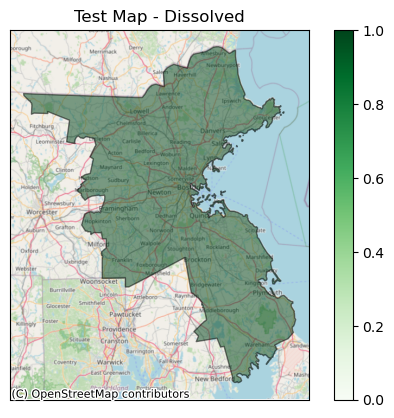

In [10]:
#Plot for test
ax = cem.plot_map(
    polygon_block_groups_collapsed,
    "TOTAL_POPULATION",
    cmap="Greens",
    edgecolor="black",
    alpha=0.5,
    with_background=True,
    legend=True,
    vmin=0.0,
    vmax=1.0,
)

ax.set_title("Test Map - Dissolved")

ax.tick_params(
    left=False,
    right=False,
    bottom=False,
    labelleft=False,
    labelbottom=False,
)

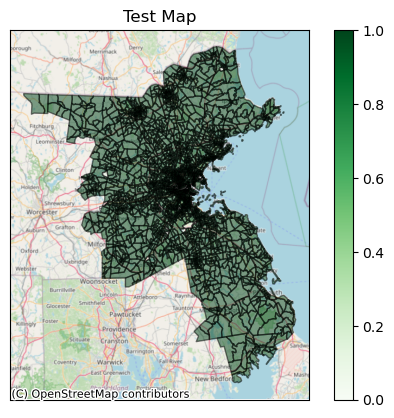

In [11]:
ax = cem.plot_map(
    polygon_block_groups,
    "TOTAL_POPULATION",
    cmap="Greens",
    edgecolor="black",
    alpha=0.5,
    with_background=True,
    legend=True,
    vmin=0.0,
    vmax=1.0,
)

ax.set_title("Test Map")

ax.tick_params(
    left=False,
    right=False,
    bottom=False,
    labelleft=False,
    labelbottom=False,
)

# Load Features

In [18]:
features = [
    # 'Aerialway',
    ##'Aeroway',
    # 'Amenity',
    # 'Barrier',
    # 'Boundary',
    # 'Building',
    # 'Craft',
    # 'Emergency',
    ##'Geological',
    # 'Healthcare',
    # 'Highway',
    # 'Historic',
    # 'Landuse',
    # 'Leisure',
    # 'Man_made',
    # 'Military',
    # 'Natural',
    # 'Office',
    # 'Place',
    # 'Power',
    # 'Public_transport',
    # 'Railway',
    # 'Route',
    # 'Shop',
    # 'Sport',
    # 'Telecom',
    # 'Tourism',
    # 'Water',
    # 'Waterway'
]

In [19]:
map_features = pd.read_csv(f'./Map Features/{features[0]}.csv')
map_features = map_features.dropna(axis='columns', how='all')
print("Number of features:", map_features.shape[0])
map_features

Number of features: 24


,key,value
0,Aeroways,Aerodrome
1,Aeroways,Aircraft crossings
2,Aeroways,Aircraft parking
3,Aeroways,Airstrip
4,Aeroways,Apron
5,Aeroways,Arresting gear
6,Aeroways,Compass rose
7,Aeroways,Gate
8,Aeroways,Grass
9,Aeroways,Hangar


In [20]:
map_features_points = pd.DataFrame()

for index, row in map_features.iterrows():
    # Create a dictionary for the current row
    print("index: ", index)
    # print("row: :", row)
    tag = {row.iloc[0]: row.iloc[1]} #make dictionary tag by selecting the key values
    print(tag)

    try:
        map_poi = ox.features.features_from_polygon(polygon_block_groups_collapsed['geometry'][0], tags=tag) #pick polygon shape from dataframe
        map_poi = map_poi.reset_index() #clean index
        map_poi = map_poi[['element_type','osmid','name','geometry']] #keep only useful columns
        map_poi['feature_category'] = row.iloc[0]
        map_poi['feature_type'] = row.iloc[0]+'_'+ row.iloc[1] #create map_feature "name type"
        map_features_points = pd.concat([map_features_points, map_poi])

    except Exception as e:
        print(e)
        continue
map_features_points.reset_index(inplace=True)

index:  0
{'Aeroways': 'Aerodrome'}
No data elements in server response. Check log and query location/tags.
index:  1
{'Aeroways': 'Aircraft crossings'}
No data elements in server response. Check log and query location/tags.
index:  2
{'Aeroways': 'Aircraft parking'}
No data elements in server response. Check log and query location/tags.
index:  3
{'Aeroways': 'Airstrip'}
No data elements in server response. Check log and query location/tags.
index:  4
{'Aeroways': 'Apron'}
No data elements in server response. Check log and query location/tags.
index:  5
{'Aeroways': 'Arresting gear'}
No data elements in server response. Check log and query location/tags.
index:  6
{'Aeroways': 'Compass rose'}
No data elements in server response. Check log and query location/tags.
index:  7
{'Aeroways': 'Gate'}
No data elements in server response. Check log and query location/tags.
index:  8
{'Aeroways': 'Grass'}
No data elements in server response. Check log and query location/tags.
index:  9
{'Aerowa

In [22]:
map_features_points

,index


In [21]:
# Intersect Map Feature Points with Block Group Polygons
# Step 1: Ensure CRS matches
polygon_block_groups.crs = map_features_points.crs

AttributeError: 'DataFrame' object has no attribute 'crs'

In [ ]:
#join all point features to polygons one by one
joined_gdf_temp = pd.DataFrame() #create empty dataframe
joined_gdf = pd.DataFrame() #create empty dataframe

for j in range(len(polygon_block_groups)):http://localhost:8888/lab/tree/OneDrive/Documents/Git%20Projects/MeridianXYZ/notebooks/~/AppData/Local/Temp/ipykernel_20824/3990302612.py
    try:
        joined_gdf_temp = gpd.sjoin(map_features_points, polygon_block_groups[j:j+1], how='right', predicate='intersects')
    except Exception as e:
        print(e)
        continue
    joined_gdf = pd.concat([joined_gdf, joined_gdf_temp])

# Step 2: Spatial Join - This adds the polygon information to each point that falls within it
# joined_gdf = gpd.sjoin(map_features_points, polygon_block_groups, how='right', predicate='intersects')
joined_gdf = joined_gdf.drop((['collapse']), axis=1)

# Step 3: Aggregation - Count points per category within each polygon
counts = joined_gdf.groupby(['NAME', 'feature_type']).size().unstack(fill_value=0).reset_index()


gdf_polygons_with_counts = polygon_block_groups.merge(counts, on="NAME", how="left").fillna(0)
gdf_polygons_with_counts = gdf_polygons_with_counts.drop((['collapse']), axis=1)

In [ ]:
gdf_polygons_with_counts.drop((['geometry']), axis=1).to_csv(f'./Map Features/{date}_polygons_with_counts_nogeo - {features[0]}.csv')
gdf_polygons_with_counts.to_csv(f'./Map Features/{date}_polygons_with_counts - {features[0]}.csv')

In [ ]:
for i in range(len(features)):
    map_features = pd.read_csv(f'./Map Features/{features[i]}.csv')
    map_features = map_features.dropna(axis='columns', how='all')
    print("Number of features:", map_features.shape[0])
    map_features
    
    map_features_points = pd.DataFrame()
    
    for index, row in map_features.iterrows():
        # Create a dictionary for the current row
        print("index: ", index)
        # print("row: :", row)
        tag = {row.iloc[0]: row.iloc[1]} #make dictionary tag by selecting the key values
        print(tag)
    
        try:
            map_poi = ox.features.features_from_polygon(polygon_block_groups_collapsed['geometry'][0], tags=tag) #pick polygon shape from dataframe
            map_poi = map_poi.reset_index() #clean index
            map_poi = map_poi[['element_type','osmid','name','geometry']] #keep only useful columns
            map_poi['feature_category'] = row.iloc[0]
            map_poi['feature_type'] = row.iloc[0]+'_'+ row.iloc[1] #create map_feature "name type"
            map_features_points = pd.concat([map_features_points, map_poi])
    
        except Exception as e:
            print(e)
            continue
    map_features_points.reset_index(inplace=True)
    
    # Intersect Map Feature Points with Block Group Polygons
    # Step 1: Ensure CRS matches
    polygon_block_groups.crs = map_features_points.crs
    
    #join all point features to polygons one by one
    joined_gdf_temp = pd.DataFrame() #create empty dataframe
    joined_gdf = pd.DataFrame() #create empty dataframe
    
    for j in range(len(polygon_block_groups)):
        try:
            joined_gdf_temp = gpd.sjoin(map_features_points, polygon_block_groups[j:j+1], how='right', predicate='intersects')
        except Exception as e:
            print(e)
            continue
        joined_gdf = pd.concat([joined_gdf, joined_gdf_temp])
    
    # Step 2: Spatial Join - This adds the polygon information to each point that falls within it
    # joined_gdf = gpd.sjoin(map_features_points, polygon_block_groups, how='right', predicate='intersects')
    joined_gdf = joined_gdf.drop((['collapse']), axis=1)
    
    # Step 3: Aggregation - Count points per category within each polygon
    counts = joined_gdf.groupby(['NAME', 'feature_type']).size().unstack(fill_value=0).reset_index()
    
    
    gdf_polygons_with_counts = polygon_block_groups.merge(counts, on="NAME", how="left").fillna(0)
    gdf_polygons_with_counts = gdf_polygons_with_counts.drop((['collapse']), axis=1)
    
    gdf_polygons_with_counts.drop((['geometry']), axis=1).to_csv(f'./Map Features/{date}_polygons_with_counts_nogeo - {features[i]}.csv')
    gdf_polygons_with_counts.to_csv(f'./Map Features/{date}_polygons_with_counts - {features[i]}.csv')